In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import json

In [2]:
#to connect with sqlserver
server = r'DESKTOP-QN0V8EP\SQLEXPRESS01'
database = 'Financial_Transactions'
conn = pyodbc.connect(
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'Trusted_Connection=yes;'
)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

In [4]:
df_users = pd.read_sql("SELECT * FROM users_data", conn)
df_cards = pd.read_sql("SELECT * FROM cards_data", conn)

C:\Users\User\AppData\Local\Temp\ipykernel_9168\3030303455.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_users = pd.read_sql("SELECT * FROM users_data", conn)
C:\Users\User\AppData\Local\Temp\ipykernel_9168\3030303455.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cards = pd.read_sql("SELECT * FROM cards_data", conn)


In [5]:
print("Users:")
print(df_users.head())

print("cards:")
print(df_users.head())

Users:
   id  current_age  retirement_age  birth_year  birth_month  gender                      address   latitude   longitude  per_capita_income  yearly_income  total_debt  credit_score  num_credit_cards
0   0           33              69        1986            3    Male              858 Plum Avenue  43.590000  -70.330002            29237.0        59613.0     36199.0           763                 4
1   1           43              74        1976            4  Female               113 Burns Lane  30.440001  -87.180000            22247.0        45360.0     14587.0           704                 3
2   2           48              64        1971            8    Male           6035 Forest Avenue  40.840000  -73.870003            13461.0        27447.0     80850.0           673                 5
3   3           49              65        1970           12    Male               840 Elm Avenue  33.889999  -98.510002            13705.0        27943.0     18693.0           681                 4
4  

In [6]:
chunksize = 500000
if not os.path.exists("transactions_part_0.parquet"):
   for i, chunk in enumerate(pd.read_sql("SELECT * FROM transactions", conn, chunksize=chunksize)):
       chunk.to_parquet(f"transactions_part_{i}.parquet", engine="pyarrow")
       print(f"✅ Saved chunk {i} with {len(chunk)} rows")
else:
   print("Files already exist, skipping export.")

Files already exist, skipping export.


In [7]:
files = glob.glob("transactions_part_*.parquet")
df_transactions = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
print("3000000:", len(df_transactions))
print(df_transactions.head())

3000000: 13305915
        id                date  client_id  card_id   amount           use_chip  merchant_id merchant_city merchant_state      zip   mcc errors
0  7475327 2010-01-01 00:01:00       1556     2972  $-77.00  Swipe Transaction        59935        Beulah             ND  58523.0  5499   None
1  7475328 2010-01-01 00:02:00        561     4575   $14.57  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   None
2  7475329 2010-01-01 00:02:00       1129      102   $80.00  Swipe Transaction        27092         Vista             CA  92084.0  4829   None
3  7475331 2010-01-01 00:05:00        430     2860  $200.00  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   None
4  7475332 2010-01-01 00:06:00        848     3915   $46.41  Swipe Transaction        13051       Harwood             MD  20776.0  5813   None


In [8]:
duplicates1 = df_users[df_users.duplicated()]
print(f"NO.of duplicates in users : {len(duplicates1)}")

duplicates2 = df_transactions[df_transactions.duplicated()]
print(f"NO.of duplicates in transaction : {len(duplicates2)}")

duplicates3 = df_cards[df_cards.duplicated()]
print(f"NO.of duplicates in cards : {len(duplicates3)}")

NO.of duplicates in users : 0
NO.of duplicates in transaction : 0
NO.of duplicates in cards : 0


In [9]:
merged = df_transactions.merge(
   df_cards,
   left_on="card_id",
    right_on="id",
    how="left",
    suffixes=("", "_card")
)
print(merged)

                id                date  client_id  card_id    amount           use_chip  merchant_id   merchant_city merchant_state      zip   mcc errors  id_card  client_id_card  card_brand        card_type       card_number  expires  cvv  has_chip  num_cards_issued  credit_limit acct_open_date  year_pin_last_changed card_on_dark_web
0          7475327 2010-01-01 00:01:00       1556     2972   $-77.00  Swipe Transaction        59935          Beulah             ND  58523.0  5499   None     2972            1556  Mastercard  Debit (Prepaid)  5497590243197280  07/2022  306      True                 2          55.0        05/2008                   2008               No
1          7475328 2010-01-01 00:02:00        561     4575    $14.57  Swipe Transaction        67570      Bettendorf             IA  52722.0  5311   None     4575             561  Mastercard           Credit  5175842699412235  12/2024  438      True                 1        9100.0        09/2005                   2015       

In [10]:
final_df = merged.merge(
    df_users ,
    left_on="client_id",
    right_on="id",
    how="left",
    suffixes=("", "_user")
)
print(final_df)

                id                date  client_id  card_id    amount           use_chip  merchant_id   merchant_city merchant_state      zip   mcc errors  id_card  client_id_card  card_brand        card_type       card_number  expires  cvv  has_chip  num_cards_issued  credit_limit acct_open_date  year_pin_last_changed card_on_dark_web  id_user  current_age  retirement_age  birth_year  birth_month  gender                   address   latitude   longitude  per_capita_income  yearly_income  total_debt  credit_score  num_credit_cards
0          7475327 2010-01-01 00:01:00       1556     2972   $-77.00  Swipe Transaction        59935          Beulah             ND  58523.0  5499   None     2972            1556  Mastercard  Debit (Prepaid)  5497590243197280  07/2022  306      True                 2          55.0        05/2008                   2008               No     1556           30              67        1989            7  Female  594 Mountain View Street  46.799999 -100.760002         

In [11]:
final_df = final_df.drop(columns=["id_card", "id_user","client_id_card","zip","card_number","cvv"
,"acct_open_date","year_pin_last_changed","birth_year","retirement_age","birth_month","address",
"per_capita_income","user_id"], errors="ignore")

In [12]:
final_df['date'] = pd.to_datetime(final_df['date'], errors='coerce')
print(final_df['date'].dtype)
final_df['date only'] = final_df['date'].dt.date
final_df['time'] = final_df['date'].dt.time
final_df = final_df.drop(columns=["date"])
print(final_df)

datetime64[ns]
                id  client_id  card_id    amount           use_chip  merchant_id   merchant_city merchant_state   mcc errors  card_brand        card_type  expires  has_chip  num_cards_issued  credit_limit card_on_dark_web  current_age  gender   latitude   longitude  yearly_income  total_debt  credit_score  num_credit_cards   date only      time
0          7475327       1556     2972   $-77.00  Swipe Transaction        59935          Beulah             ND  5499   None  Mastercard  Debit (Prepaid)  07/2022      True                 2          55.0               No           30  Female  46.799999 -100.760002        48277.0    110153.0           740                 4  2010-01-01  00:01:00
1          7475328        561     4575    $14.57  Swipe Transaction        67570      Bettendorf             IA  5311   None  Mastercard           Credit  12/2024      True                 1        9100.0               No           48    Male  40.799999  -91.120003        36853.0    112139.

In [13]:
null_state = final_df[final_df['merchant_state'].isna()]
print(null_state)

print(final_df.loc[final_df['merchant_state'].isna(), 'merchant_city'].unique())

final_df.loc[final_df['merchant_state'].isna(), 'merchant_state'] = "Online"

                id  client_id  card_id   amount            use_chip  merchant_id merchant_city merchant_state   mcc errors  card_brand        card_type  expires  has_chip  num_cards_issued  credit_limit card_on_dark_web  current_age  gender   latitude   longitude  yearly_income  total_debt  credit_score  num_credit_cards   date only      time
7          7475335       1684     2140   $26.46  Online Transaction        39021        ONLINE           None  4784   None  Mastercard  Debit (Prepaid)  05/2021      True                 1          46.0               No           56    Male  36.340000  -83.279999        27861.0    108313.0           782                 5  2010-01-01  00:14:00
8          7475336        335     5131  $261.58  Online Transaction        50292        ONLINE           None  7801   None        Visa            Debit  06/2020      True                 1       23401.0               No           46  Female  26.740000  -80.120003        56467.0     66565.0           688      

In [14]:
print(final_df)

                id  client_id  card_id    amount           use_chip  merchant_id   merchant_city merchant_state   mcc errors  card_brand        card_type  expires  has_chip  num_cards_issued  credit_limit card_on_dark_web  current_age  gender   latitude   longitude  yearly_income  total_debt  credit_score  num_credit_cards   date only      time
0          7475327       1556     2972   $-77.00  Swipe Transaction        59935          Beulah             ND  5499   None  Mastercard  Debit (Prepaid)  07/2022      True                 2          55.0               No           30  Female  46.799999 -100.760002        48277.0    110153.0           740                 4  2010-01-01  00:01:00
1          7475328        561     4575    $14.57  Swipe Transaction        67570      Bettendorf             IA  5311   None  Mastercard           Credit  12/2024      True                 1        9100.0               No           48    Male  40.799999  -91.120003        36853.0    112139.0           834

In [15]:

final_df["errors"] = final_df["errors"].fillna("No errors")

print(final_df) 


                id  client_id  card_id    amount           use_chip  merchant_id   merchant_city merchant_state   mcc     errors  card_brand        card_type  expires  has_chip  num_cards_issued  credit_limit card_on_dark_web  current_age  gender   latitude   longitude  yearly_income  total_debt  credit_score  num_credit_cards   date only      time
0          7475327       1556     2972   $-77.00  Swipe Transaction        59935          Beulah             ND  5499  No errors  Mastercard  Debit (Prepaid)  07/2022      True                 2          55.0               No           30  Female  46.799999 -100.760002        48277.0    110153.0           740                 4  2010-01-01  00:01:00
1          7475328        561     4575    $14.57  Swipe Transaction        67570      Bettendorf             IA  5311  No errors  Mastercard           Credit  12/2024      True                 1        9100.0               No           48    Male  40.799999  -91.120003        36853.0    112139.0  

In [16]:
no_errors_count = (final_df['errors'] == "No Error").sum()
with_errors_count = final_df[final_df['errors'] != "No Error"]['errors'].value_counts()

print("No Error:", no_errors_count)
print("Errors:")
print(with_errors_count)


No Error: 0
Errors:
errors
No errors                                                13094522
Insufficient Balance                                       130902
Bad PIN                                                     32119
Technical Glitch                                            26271
Bad Card Number                                              7767
Bad Expiration                                               6161
Bad CVV                                                      6106
Bad Zipcode                                                  1126
"Bad PIN,Insufficient Balance"                                293
"Insufficient Balance,Technical Glitch"                       243
"Bad Card Number,Insufficient Balance"                         71
"Bad PIN,Technical Glitch"                                     70
"Bad CVV,Insufficient Balance"                                 57
"Bad Expiration,Insufficient Balance"                          47
"Bad Card Number,Bad CVV"                        

In [17]:
with open(r"C:\Users\User\Downloads\archive (7)\mcc_codes.json", "r") as f:
    mcc_data = json.load(f)
mcc_df = pd.DataFrame(list(mcc_data.items()), columns=["mcc", "description"])

In [18]:
final_df["mcc"] = final_df["mcc"].astype(int)
mcc_df["mcc"] = mcc_df["mcc"].astype(int)

final_df = final_df.merge(mcc_df, on="mcc", how="left")
final_df = final_df.drop(columns=["mcc"])


In [19]:
with open(r"C:\Users\User\Downloads\archive (7)\train_fraud_labels.json", "r", encoding="utf-8") as f:
    fraud_data = json.load(f)
fraud_dict = fraud_data["target"]
fraud_df = pd.DataFrame(list(fraud_dict.items()), columns=["id", "fraud_label"])
fraud_df["id"] = fraud_df["id"].astype(int)
final_df = final_df.merge(fraud_df, left_on="id", right_on="id", how="left")
print(fraud_df.head())


         id fraud_label
0  10649266          No
1  23410063          No
2   9316588          No
3  12478022          No
4   9558530          No


In [20]:
print(final_df.isnull().sum())

id                        0
client_id                 0
card_id                   0
amount                    0
use_chip                  0
merchant_id               0
merchant_city             0
merchant_state            0
errors                    0
card_brand                0
card_type                 0
expires                   0
has_chip                  0
num_cards_issued          0
credit_limit              0
card_on_dark_web          0
current_age               0
gender                    0
latitude                  0
longitude                 0
yearly_income             0
total_debt                0
credit_score              0
num_credit_cards          0
date only                 0
time                      0
description               0
fraud_label         4390952
dtype: int64


In [21]:
final_df["fraud_label"] = final_df["fraud_label"].fillna("No")
print(final_df.isnull().sum())

id                  0
client_id           0
card_id             0
amount              0
use_chip            0
merchant_id         0
merchant_city       0
merchant_state      0
errors              0
card_brand          0
card_type           0
expires             0
has_chip            0
num_cards_issued    0
credit_limit        0
card_on_dark_web    0
current_age         0
gender              0
latitude            0
longitude           0
yearly_income       0
total_debt          0
credit_score        0
num_credit_cards    0
date only           0
time                0
description         0
fraud_label         0
dtype: int64


In [22]:
print(final_df["fraud_label"].value_counts(normalize=True))

fraud_label
No     0.998998
Yes    0.001002
Name: proportion, dtype: float64


In [23]:
final_df = final_df.rename(columns={"description": "merchant_type"})

In [24]:
top_merchant_types = (
    final_df["merchant_type"]
    .value_counts()
    .head(10)   # top 10
)

print("Top 10 Merchant Types by Number of Transactions:")
print(top_merchant_types)


Top 10 Merchant Types by Number of Transactions:
merchant_type
Grocery Stores, Supermarkets     1592584
Miscellaneous Food Stores        1460875
Service Stations                 1424711
Eating Places and Restaurants     999738
Drug Stores and Pharmacies        772913
Tolls and Bridge Fees             674135
Wholesale Clubs                   601942
Money Transfer                    589140
Taxicabs and Limousines           500662
Fast Food Restaurants             499659
Name: count, dtype: int64


In [25]:
final_df['amount'] = final_df['amount'].replace('[\$,]', '', regex=True).astype(float)


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\User\AppData\Local\Temp\ipykernel_9168\474862619.py:1: SyntaxWarning: invalid escape sequence '\$'
  final_df['amount'] = final_df['amount'].replace('[\$,]', '', regex=True).astype(float)


In [26]:
top_merchants_amount = final_df.groupby('merchant_type')['amount'].sum().sort_values(ascending=False).head(10)
print(top_merchants_amount)

merchant_type
Money Transfer                                53158515.64
Grocery Stores, Supermarkets                  40970754.15
Wholesale Clubs                               37697546.74
Drug Stores and Pharmacies                    35113527.69
Service Stations                              29570426.66
Utilities - Electric, Gas, Water, Sanitary    27650038.08
Department Stores                             27031968.70
Eating Places and Restaurants                 26348225.47
Automotive Service Shops                      24955640.73
Telecommunication Services                    24726472.83
Name: amount, dtype: float64


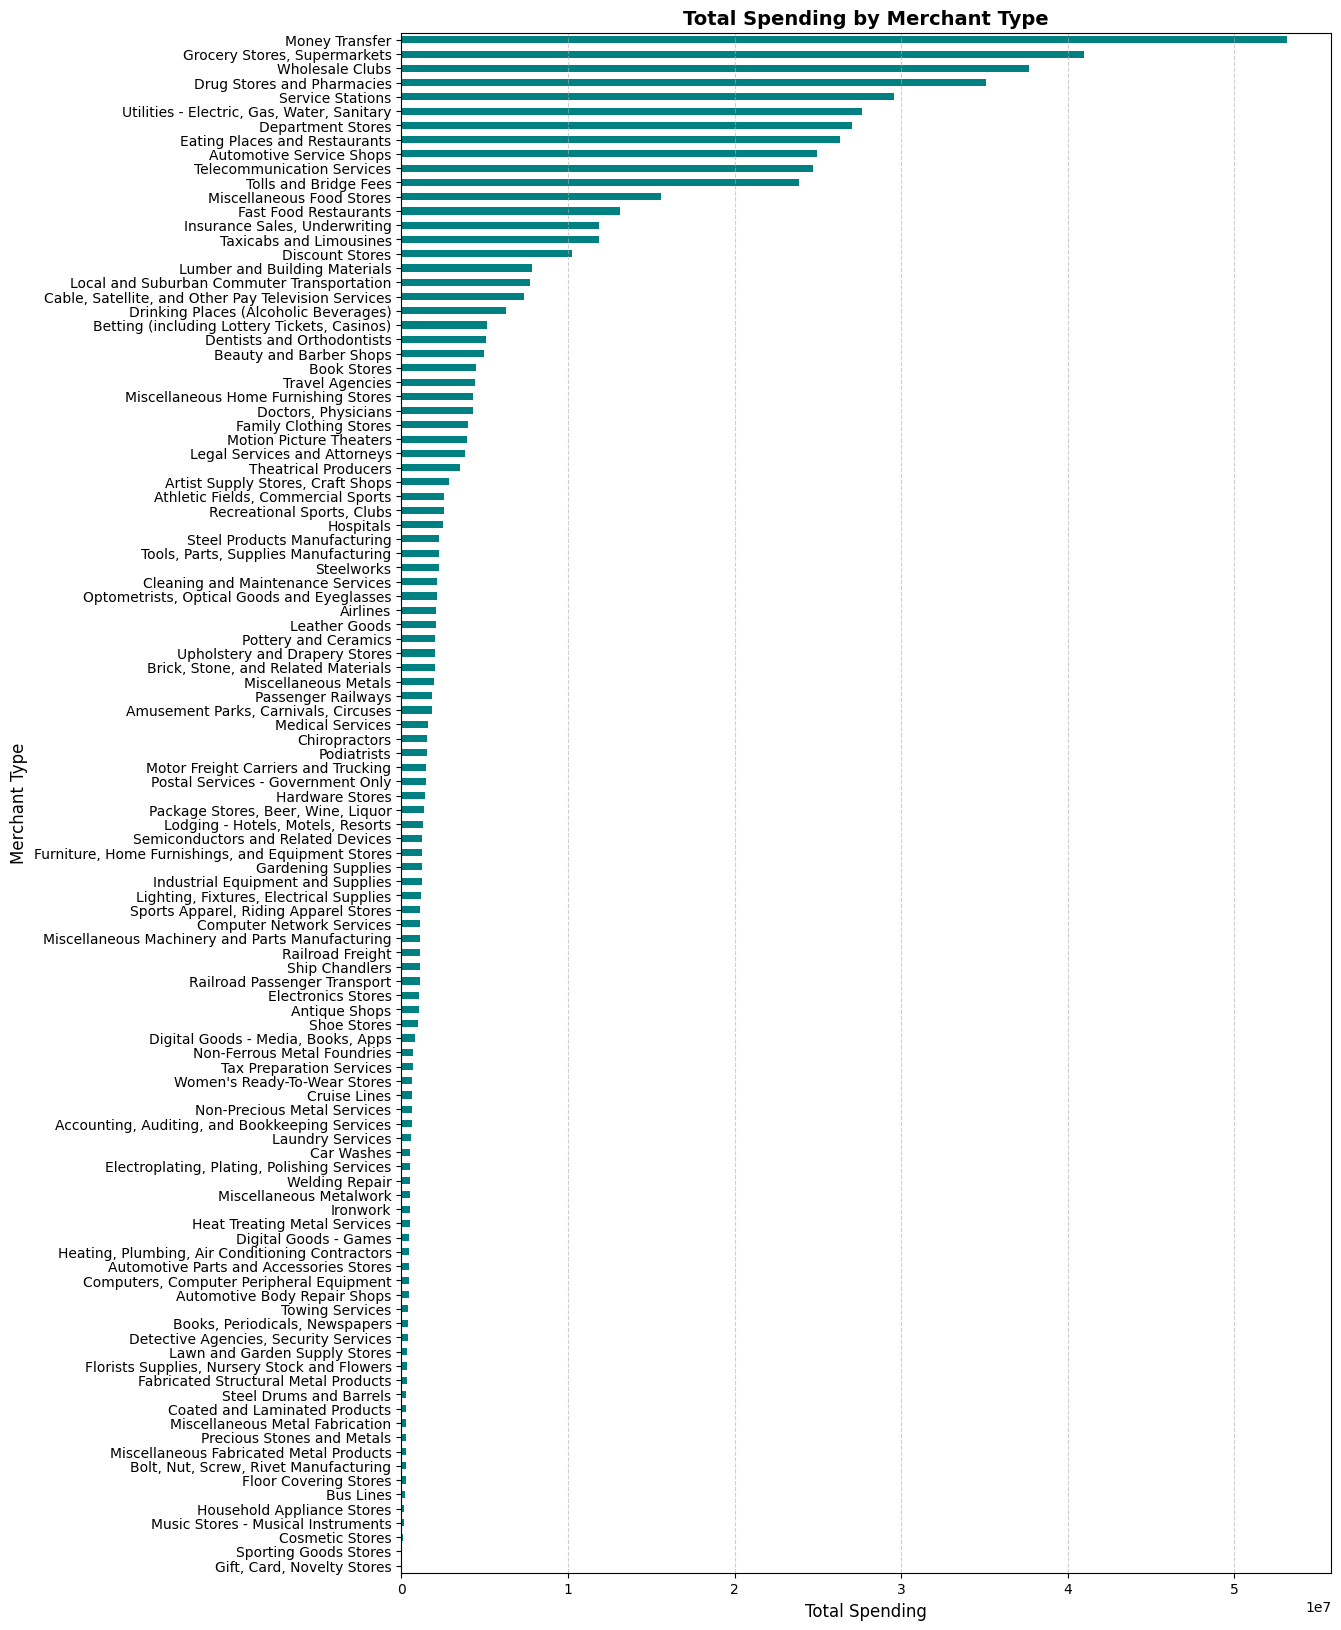

In [90]:
merchant_type_spending = final_df.groupby('merchant_type')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,20))
merchant_type_spending.plot(kind='barh', color='teal')
plt.title('Total Spending by Merchant Type', fontsize=14, weight='bold')
plt.xlabel('Total Spending', fontsize=12)
plt.ylabel('Merchant Type', fontsize=12)
plt.gca().invert_yaxis()  # يخلي أكبر merchant type فوق
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [27]:
merchant_gender = (
    final_df.groupby(['merchant_type', 'gender'])['amount']
    .sum()
    .reset_index()
    .sort_values(by=['merchant_type', 'amount'], ascending=[True, False])
)

print(merchant_gender)


                                      merchant_type  gender       amount
0    Accounting, Auditing, and Bookkeeping Services  Female    381661.76
1    Accounting, Auditing, and Bookkeeping Services    Male    262694.18
2                                          Airlines  Female   1054421.00
3                                          Airlines    Male   1033627.69
5              Amusement Parks, Carnivals, Circuses    Male    931614.00
..                                              ...     ...          ...
211                                  Welding Repair    Male    248503.35
212                                 Wholesale Clubs  Female  19831861.08
213                                 Wholesale Clubs    Male  17865685.66
214                    Women's Ready-To-Wear Stores  Female    347620.03
215                    Women's Ready-To-Wear Stores    Male    318588.07

[216 rows x 3 columns]


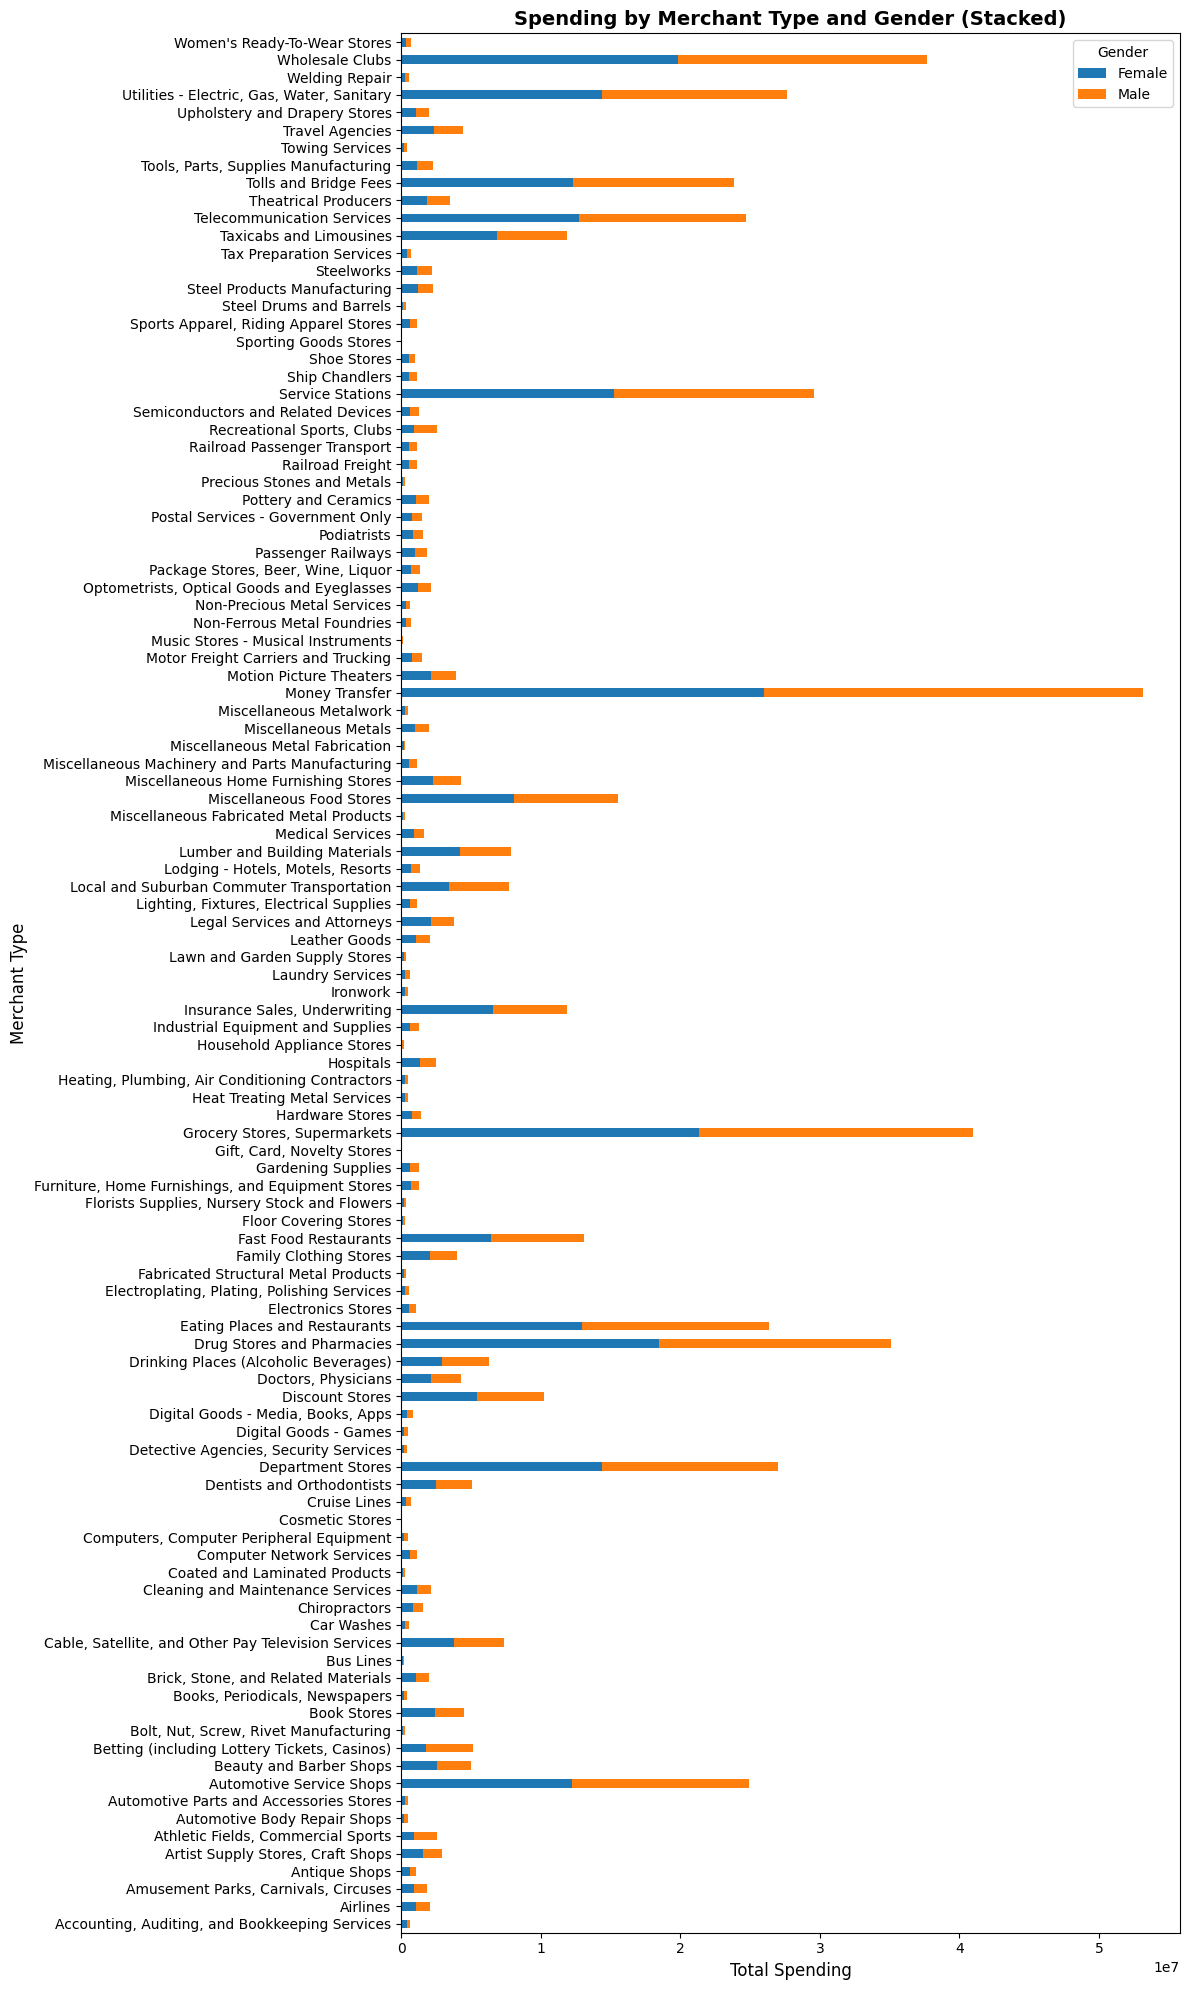

In [63]:
pivot_df = merchant_gender.pivot(index='merchant_type', columns='gender', values='amount').fillna(0)

pivot_df.plot(kind='barh', stacked=True, figsize=(12, 20))  # horizontal + طول أكبر
plt.title('Spending by Merchant Type and Gender (Stacked)', fontsize=14, weight='bold')
plt.xlabel('Total Spending', fontsize=12)
plt.ylabel('Merchant Type', fontsize=12)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()




In [28]:
gender_amount = final_df.groupby('gender')['amount'].sum()
gender_percentage = (gender_amount / gender_amount.sum()) * 100

print(gender_percentage)

gender
Female    51.292642
Male      48.707358
Name: amount, dtype: float64


In [29]:
gender_counts = final_df['gender'].value_counts()
print(gender_counts)

gender
Female    6815916
Male      6489999
Name: count, dtype: int64


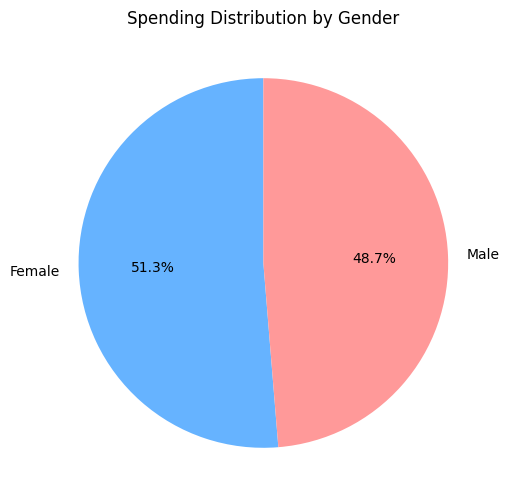

In [59]:
gender_spending = final_df.groupby('gender')['amount'].sum()
plt.figure(figsize=(6,6))
gender_spending.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Spending Distribution by Gender')
plt.ylabel('')
plt.show()


In [30]:
final_df = final_df.rename(columns={"current_age": "age"})

In [84]:
age_spending = final_df.groupby('age')['amount'].sum().sort_values(ascending=False)
print(age_spending)

age
47    22,099,117
51    19,010,766
49    16,224,069
52    15,879,744
54    15,302,200
         ...    
87     1,396,880
99     1,009,335
24       535,849
101      291,773
23       238,174
Name: amount, Length: 74, dtype: float64


In [32]:
age_counts = final_df['age'].value_counts().head(10).sort_values(ascending=False)
print(age_counts)

age
47    541132
51    409971
52    389245
49    372906
50    350911
43    350010
48    348784
46    342266
59    328724
58    324342
Name: count, dtype: int64


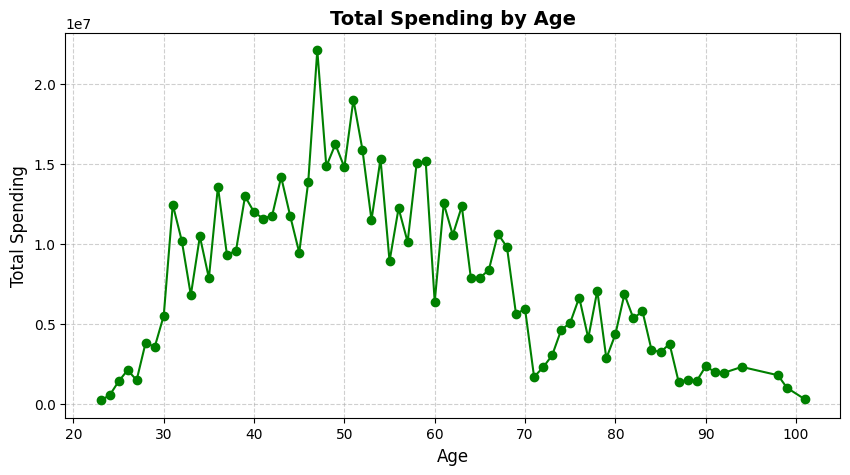

In [83]:
age_spending = final_df.groupby('age')['amount'].sum()

plt.figure(figsize=(10,5))
plt.plot(age_spending.index, age_spending.values, marker='o', linestyle='-', color='green')
plt.title('Total Spending by Age', fontsize=14, weight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [33]:
income_spending = final_df.groupby('yearly_income')['amount'].mean().sort_values(ascending=False)
print(income_spending)

yearly_income
189490.0    147.244145
88432.0     129.601911
113514.0    127.515150
249925.0    126.063315
93417.0     121.706613
               ...    
42808.0      10.595516
1.0           9.532087
2.0           7.835179
28472.0       7.141113
49026.0       5.340484
Name: amount, Length: 1201, dtype: float64


In [34]:
correlation_income = final_df['yearly_income'].corr(final_df['amount'])
print("Correlation between income and spending:", correlation_income)

Correlation between income and spending: 0.10351533825825514


In [35]:
final_df['hour'] = final_df['time'].apply(lambda t: t.hour if pd.notnull(t) else None)

hour_spending = final_df.groupby('hour')['amount'].sum().sort_values(ascending=False)
print(hour_spending)

hour
14    42112924.61
16    40506365.76
15    39870059.48
13    39432095.90
11    38462432.80
12    37317780.00
10    33468050.41
8     30926930.79
7     29703723.51
9     29677877.04
6     25789299.50
17    24074636.69
18    23788324.25
19    22579384.00
20    22163906.95
21    21617380.60
22    21308226.06
23     9501073.73
5      8363710.32
0      6937962.75
1      6627351.42
4      6367185.47
3      5673053.87
2      5565786.37
Name: amount, dtype: float64


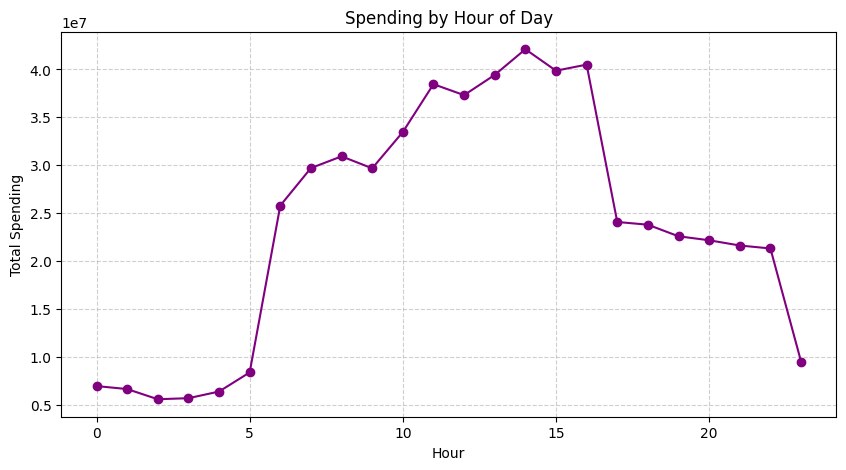

In [68]:
final_df['hour'] = final_df['time'].apply(lambda x: x.hour)
hourly_spending = final_df.groupby('hour')['amount'].sum()

plt.figure(figsize=(10,5))
hourly_spending.plot(kind='line', marker='o', color='purple')
plt.title('Spending by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Spending')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [36]:
final_df['month'] = pd.to_datetime(final_df['date only']).dt.month

month_spending = final_df.groupby('month')['amount'].sum().sort_values(ascending=False)
print(month_spending)

month
7     49696315.04
8     49510320.78
10    49435764.38
3     49314647.53
5     49192440.78
1     48706157.19
6     48424797.72
9     47944954.74
4     47797478.55
2     44522960.71
12    44388847.85
11    42900837.01
Name: amount, dtype: float64


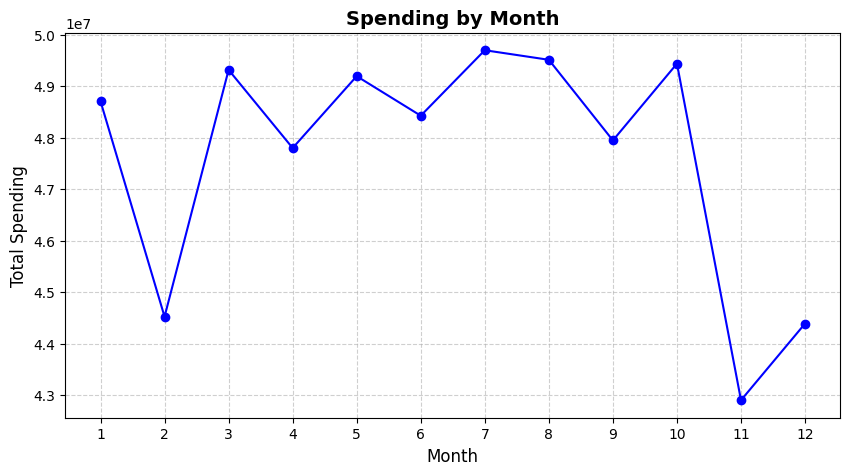

In [77]:
final_df['month'] = pd.to_datetime(final_df['date only']).dt.month
monthly_spending = final_df.groupby('month')['amount'].sum()

plt.figure(figsize=(10,5))
plt.plot(monthly_spending.index, monthly_spending.values, marker='o', linestyle='-', color='blue')
plt.title('Spending by Month', fontsize=14, weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1,13))
plt.show()



In [37]:
final_df['year'] = pd.to_datetime(final_df['date only']).dt.year

year_spending = final_df.groupby('year')['amount'].sum().sort_values(ascending=False)
print(year_spending)

year
2016    59844028.90
2017    59628480.63
2018    59627317.94
2015    59514007.43
2014    58617820.51
2013    58284939.62
2012    56832410.86
2011    55778904.96
2010    54232556.12
2019    49475055.31
Name: amount, dtype: float64


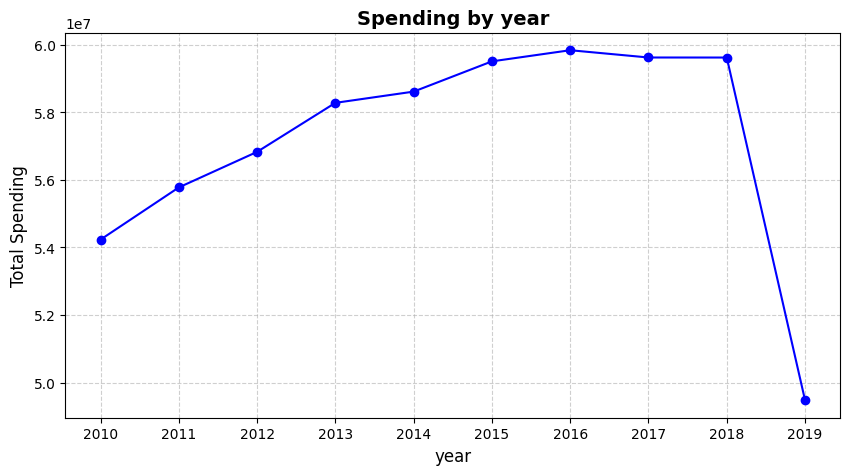

In [80]:
final_df['year'] = pd.to_datetime(final_df['date only']).dt.year
year_spending = final_df.groupby('year')['amount'].sum()

plt.figure(figsize=(10,5))
plt.plot(year_spending.index, year_spending.values, marker='o', linestyle='-', color='blue')
plt.title('Spending by year', fontsize=14, weight='bold')
plt.xlabel('year', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(year_spending.index)
plt.show()

In [38]:
card_brand_usage = final_df['card_brand'].value_counts()
print(card_brand_usage)

card_brand
Mastercard    7157399
Visa          4957563
Amex           854490
Discover       336463
Name: count, dtype: int64


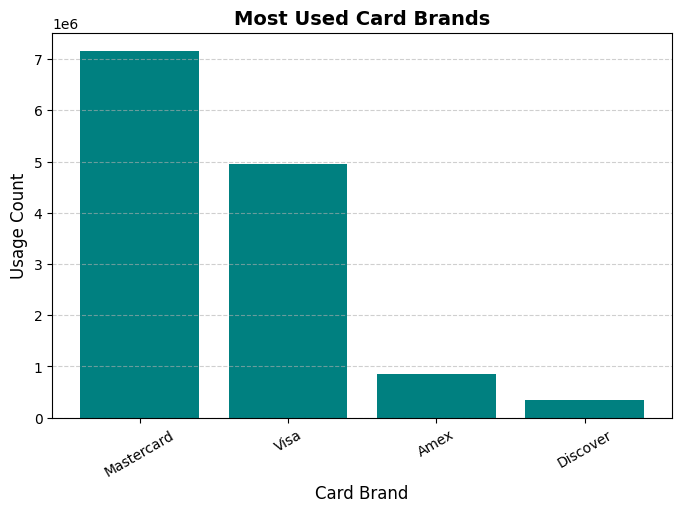

In [82]:
card_usage = final_df['card_brand'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(card_usage.index, card_usage.values, color='teal')
plt.title('Most Used Card Brands', fontsize=14, weight='bold')
plt.xlabel('Card Brand', fontsize=12)
plt.ylabel('Usage Count', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [39]:
pd.set_option('display.float_format', '{:,.0f}'.format)
card_summary = final_df.groupby("card_type")["amount"].sum().sort_values(ascending=False)
print(card_summary)


card_type
Debit             326,091,498
Credit            225,811,820
Debit (Prepaid)    19,932,204
Name: amount, dtype: float64


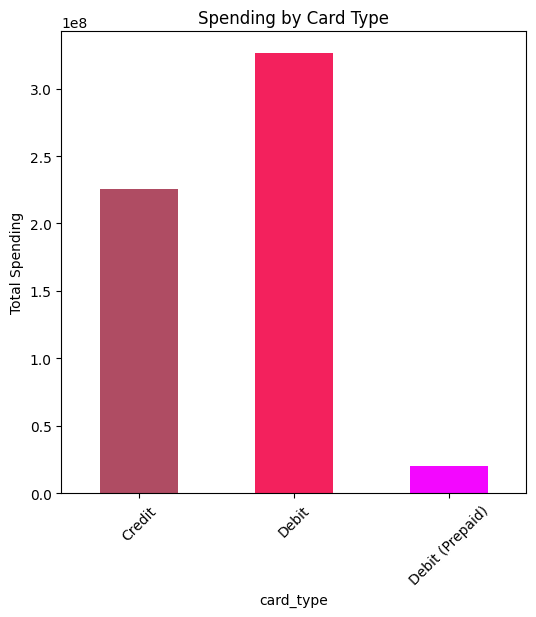

In [66]:
card_type_spending = final_df.groupby('card_type')['amount'].sum()

plt.figure(figsize=(6,6))
card_type_spending.plot(kind='bar', color=["#AF4C63", "#F3215D", "#F307FF"])
plt.title('Spending by Card Type')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()


In [40]:
cards_spending = final_df.groupby('num_credit_cards')['amount'].mean()
print(cards_spending)

num_credit_cards
1   45
2   47
3   42
4   41
5   43
6   44
7   38
8   54
9   50
Name: amount, dtype: float64


In [41]:
state_spending = final_df.groupby('merchant_state')['amount'].sum().sort_values(ascending=False).head(10)
print(state_spending)

merchant_state
Online   88,896,665
CA       59,084,616
TX       42,477,208
NY       39,721,648
FL       28,603,402
IL       19,500,278
PA       18,234,989
NC       16,790,704
OH       16,225,273
MI       15,051,464
Name: amount, dtype: float64


In [42]:
city_spending = final_df.groupby('merchant_city')['amount'].sum().sort_values(ascending=False).head(10)
print(city_spending)

merchant_city
ONLINE          88,896,665
Houston          6,615,631
Miami            3,553,177
Louisville       3,196,076
San Francisco    3,184,667
Atlanta          3,127,971
Memphis          3,080,699
Las Vegas        2,975,596
Los Angeles      2,965,266
Minneapolis      2,816,471
Name: amount, dtype: float64


In [43]:
online_offline = final_df.groupby(
    final_df['merchant_city'].str.lower().eq("online").map({True: "Online", False: "Offline"})
)['amount'].sum()

print(online_offline)


merchant_city
Offline   482,938,857
Online     88,896,665
Name: amount, dtype: float64


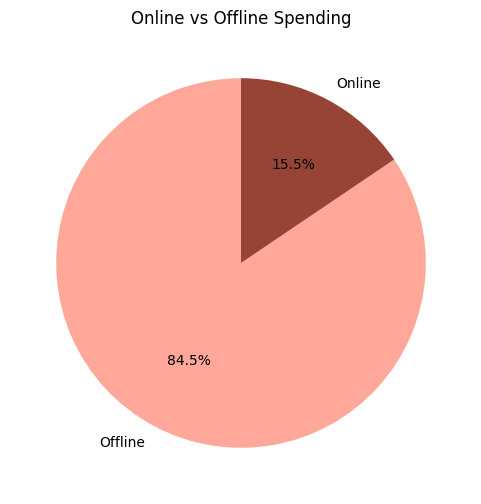

In [67]:
online_offline = final_df.groupby(final_df['merchant_city'].str.lower().eq("online"))['amount'].sum()
online_offline.index = online_offline.index.map({True: 'Online', False: 'Offline'})

plt.figure(figsize=(6,6))
online_offline.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=["#ffa799","#974336"])
plt.title('Online vs Offline Spending')
plt.ylabel('')
plt.show()

In [44]:
chip_spending = final_df.groupby('use_chip')['amount'].sum().sort_values(ascending=False)
print(chip_spending)

use_chip
Swipe Transaction    287,151,829
Chip Transaction     195,483,584
Online Transaction    89,200,110
Name: amount, dtype: float64


In [45]:
has_chip_spending = final_df.groupby(
    final_df['has_chip'].map({True: "Yes", False: "No"})
)['amount'].sum()

print(has_chip_spending)


has_chip
No     56,760,636
Yes   515,074,887
Name: amount, dtype: float64


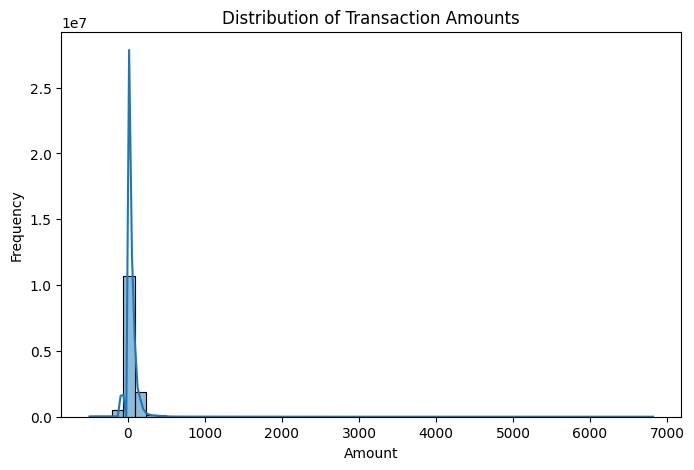

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(final_df['amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


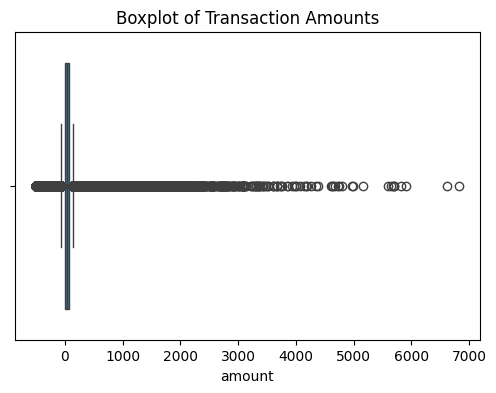

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=final_df['amount'])
plt.title("Boxplot of Transaction Amounts")
plt.show()

In [ ]:
customer_summary = final_df.groupby("client_id")['amount'].agg(['count', 'mean', 'sum']).sort_values(by="sum", ascending=False)
print(customer_summary.head(10)) 


           count  mean       sum
client_id                       
96         38617    63 2,445,773
1686       19810   109 2,167,881
1340       22023    93 2,039,921
840        15095   130 1,956,341
464        27619    68 1,882,901
490        21831    78 1,711,483
704        20748    79 1,635,022
285        32032    50 1,615,459
488        23990    67 1,611,114
1168       30520    52 1,590,823
